In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from datetime import datetime as dt 
import seaborn as sns
import missingno as ms
import math
import calendar
import geopandas as gpd
from geopy.geocoders import Nominatim
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [452]:
%load_ext autoreload
%autoreload 
%aimport MyFunctions
myfunc = MyFunctions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# read the data from the csv files
stations = pd.read_csv("example_sprit_cut_station.csv", delimiter=";")
prices = pd.read_csv("example_sprit_cut_prices.csv", delimiter=";")

In [10]:
# explore the stations dataset
stations.head()

,ID,VERSION,VERSION_TIME,NAME,BRAND,STREET,HOUSE_NUMBER,POST_CODE,PLACE,PUBLIC_HOLIDAY_IDENTIFIER,LAT,LNG
0,d37bee76-91b6-485a-b974-24f1b0d391fa,4,2015-01-09 10:26:15.000000,Aral Tankstelle,ARAL,An der Tagweide,2,76139,Karlsruhe,\N,49.020280,8.459429
1,51d4b652-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET MANNHEIM UNTERMUEHLAUSTRASSE 83,JET,UNTERMUEHLAUSTRASSE 83,\N,68169,MANNHEIM,\N,49.508962,8.467691
2,c7caf231-0e47-40db-92de-9349a2eb2bef,4,2014-09-26 13:24:57.000000,Aral Tankstelle,ARAL,Trippstadter Straße,69,67663,Kaiserslautern,\N,49.433754,7.757465
3,51d4b53b-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET KAISERSLAUTERN PARISER STR. 167,JET,PARISER STR. 167,\N,67655,KAISERSLAUTERN,\N,49.442200,7.748360
4,51d4b70f-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET GERMERSHEIM MUENCHENER STRASSE 12,JET,MUENCHENER STRASSE 12,\N,76726,GERMERSHEIM,\N,49.226800,8.374400


In [441]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 12 columns):
ID                           824 non-null object
VERSION                      824 non-null int64
VERSION_TIME                 824 non-null object
NAME                         824 non-null object
BRAND                        824 non-null object
STREET                       820 non-null object
POST_CODE                    820 non-null object
PLACE                        820 non-null object
PUBLIC_HOLIDAY_IDENTIFIER    824 non-null object
LAT                          824 non-null float64
LNG                          824 non-null float64
geometry                     824 non-null object
dtypes: float64(2), int64(1), object(9)
memory usage: 77.3+ KB


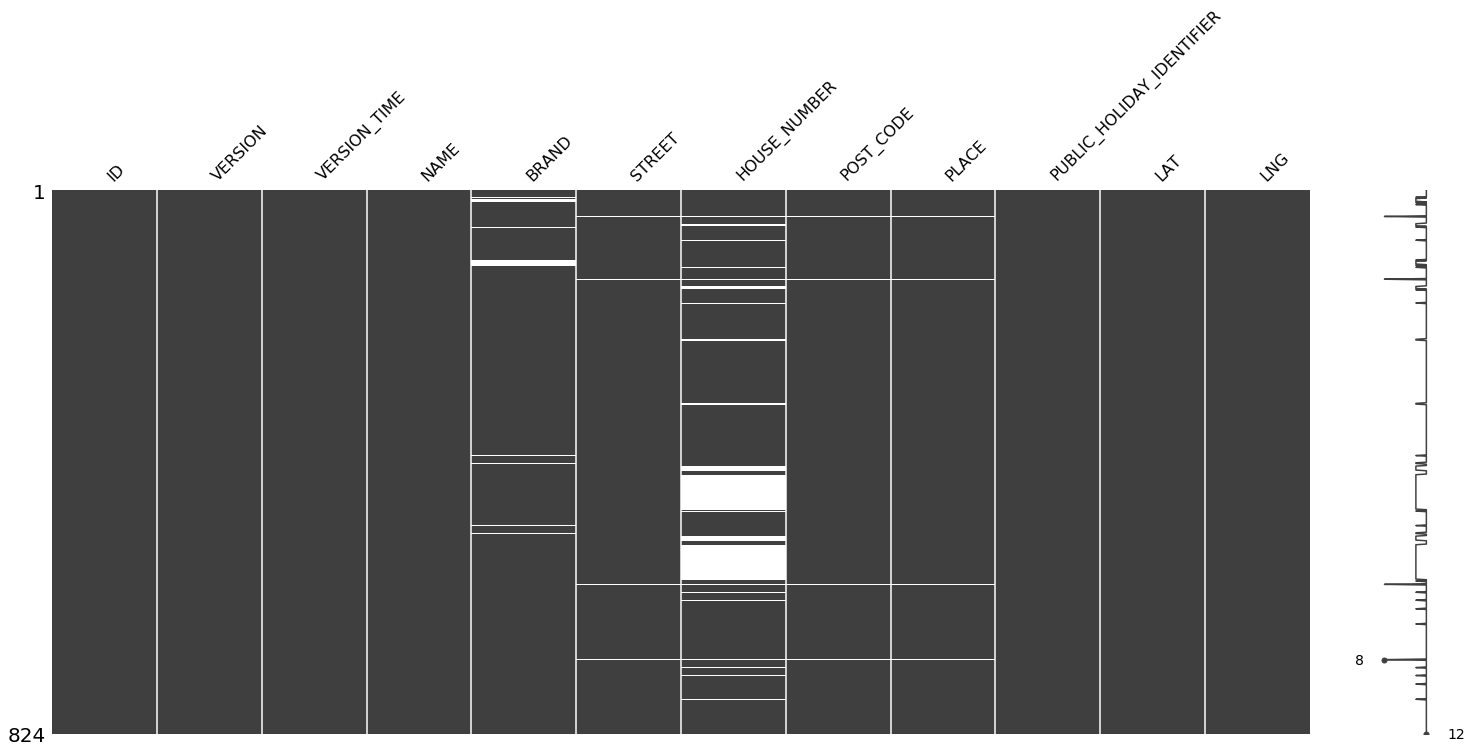

In [13]:
ms.matrix(stations)

## It seems that the stations dataset is missing some values
## Drop House number since it does not bring high meaning 

In [353]:
stations.drop('HOUSE_NUMBER', axis = 1,inplace=True)

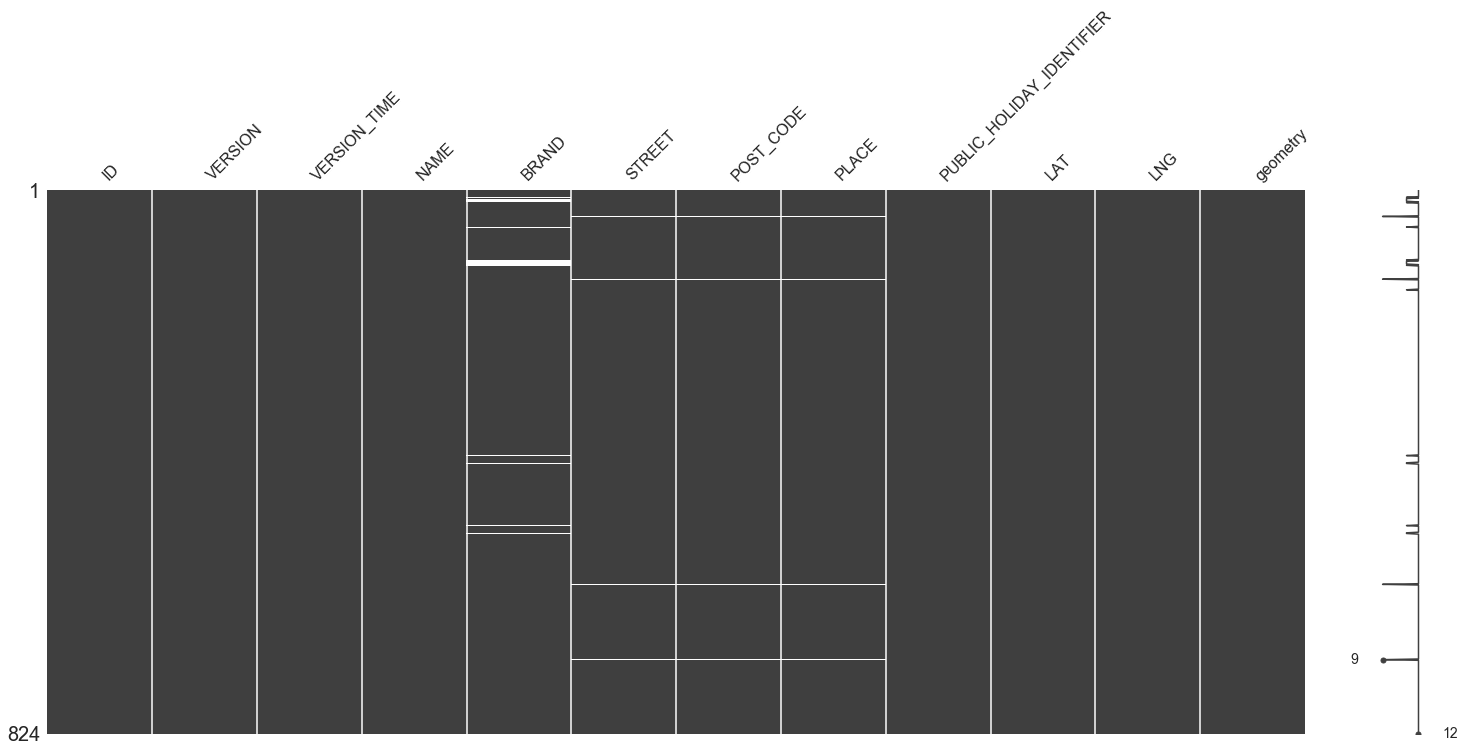

In [354]:
ms.matrix(stations)

In [364]:
def add_brand(col):
    brand = col[0]
    if pd.isnull(brand):
        return 'ARAL'
    else:
        return brand
        
    

## Add ARAL brand to the Nan values in BRAND

In [367]:
stations['BRAND'] = stations[['BRAND']].apply(add_brand,axis=1)

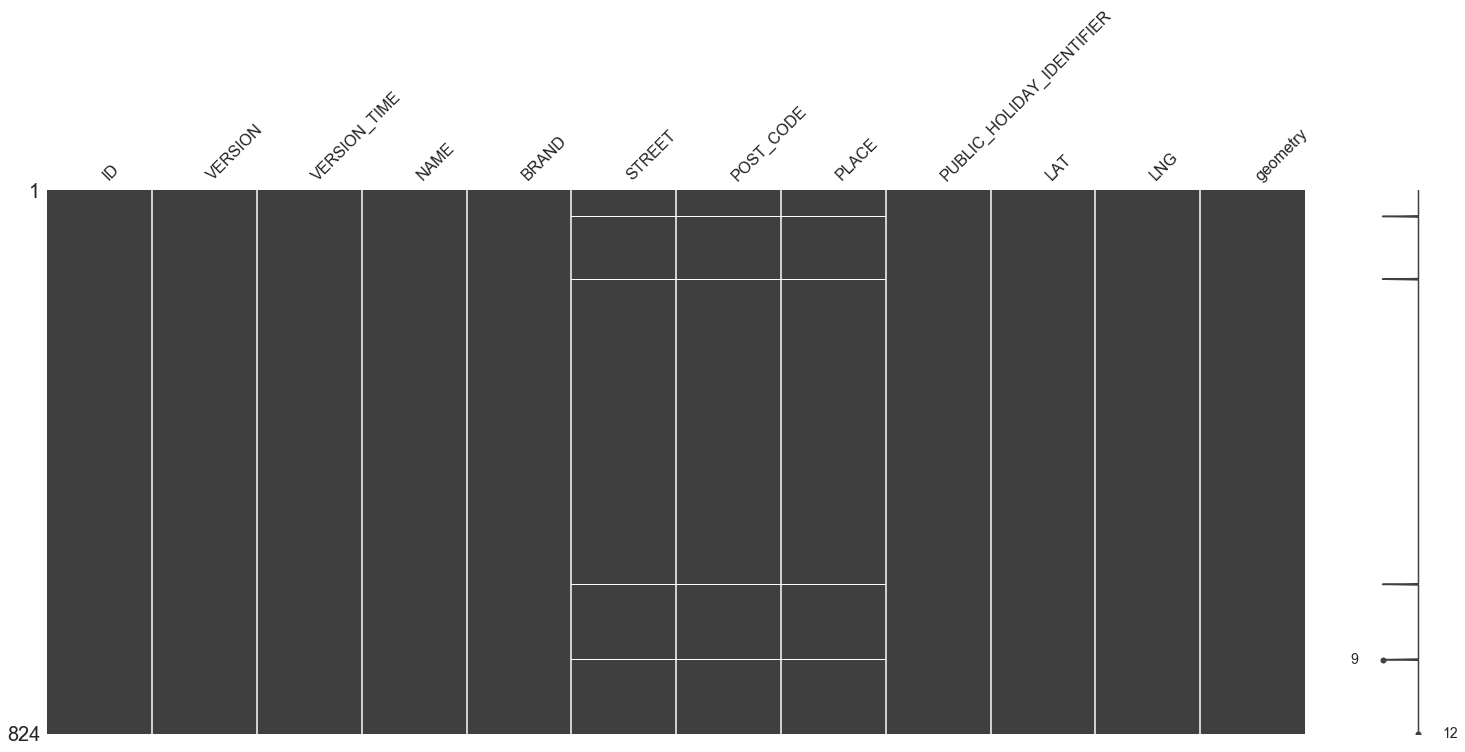

In [369]:
ms.matrix(stations)

## Now the stations data set looks better

In [12]:
# explore the prices dataset
prices.head()

,STID,E5,E10,DIESEL,DATE_CHANGED,CHANGED
0,01bf5a06-4248-43a5-9524-56123fa3ab2f,1589,1549,1389,2014-10-02 05:22:01.000000,21
1,01bf5a06-4248-43a5-9524-56123fa3ab2f,1569,1529,1369,2014-10-02 05:26:01.000000,21
2,01bf5a06-4248-43a5-9524-56123fa3ab2f,1569,1529,1359,2014-10-02 09:06:01.000000,1
3,01bf5a06-4248-43a5-9524-56123fa3ab2f,1539,1499,1339,2014-10-03 12:14:01.000000,21
4,01bf5a06-4248-43a5-9524-56123fa3ab2f,1529,1489,1329,2014-10-03 14:14:01.000000,21


In [19]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2189526 entries, 0 to 2189525
Data columns (total 6 columns):
STID            object
E5              int64
E10             int64
DIESEL          int64
DATE_CHANGED    object
CHANGED         int64
dtypes: int64(4), object(2)
memory usage: 100.2+ MB


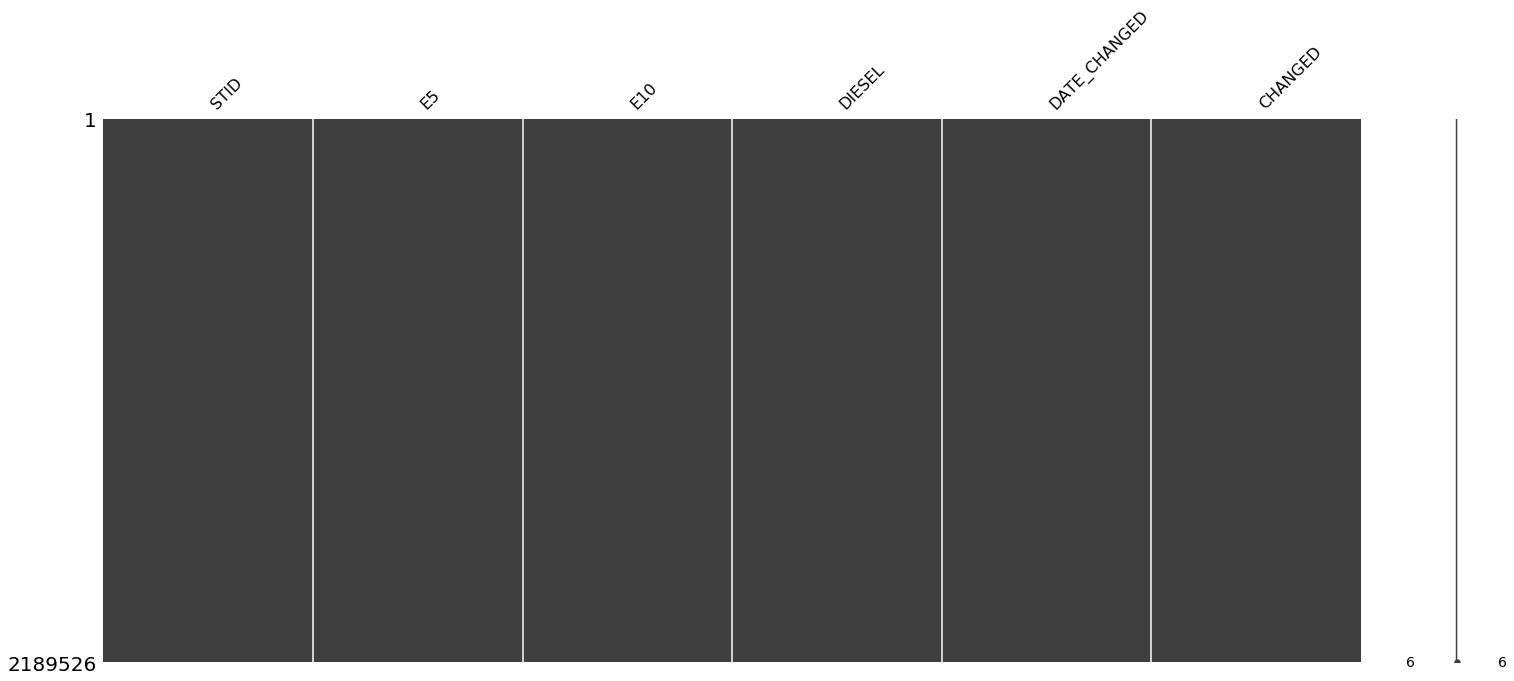

In [14]:
ms.matrix(prices)

In [334]:
unique_stids_price = prices['STID'].unique()
unique_stids_price = np.sort(unique_stids_price)

## Prices dataset looks good

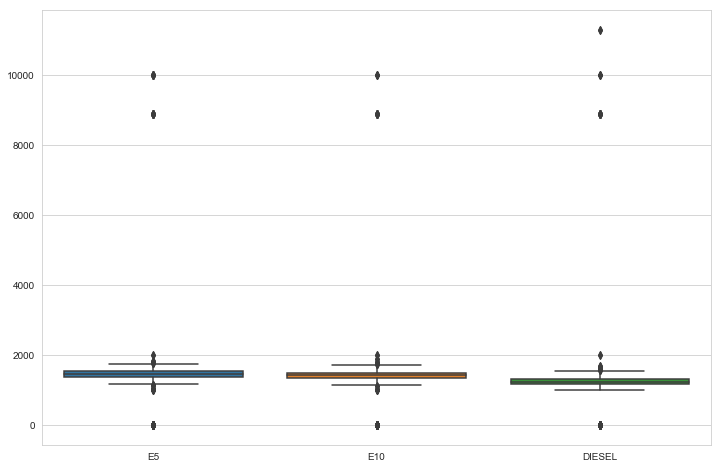

In [443]:
plt.figure(figsize=(12,8))
sns.boxplot(data=prices[['E5', 'E10', 'DIESEL']])

## There are some outliers in the prices dataset, 0 € and around 10 €. This outliers will be dealt with when computing max, min and mean.

Text(0.5, 1.0, 'prices correlation')

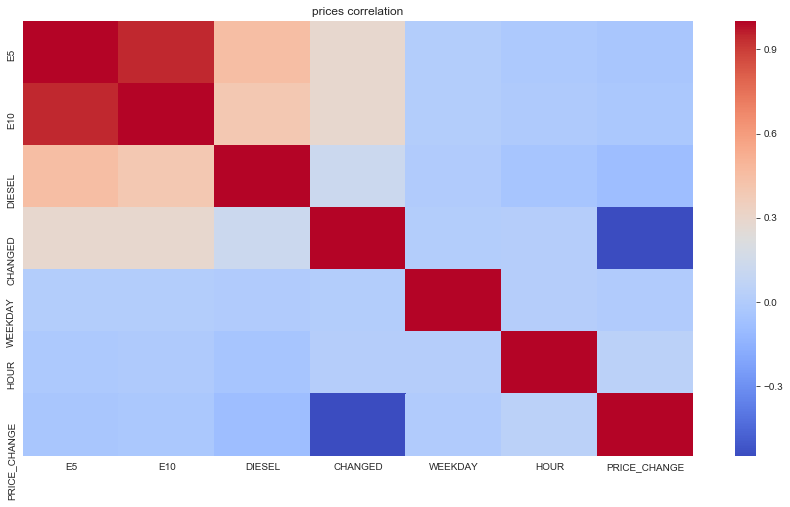

In [447]:
plt.figure(figsize=(15,8))
sns.heatmap(prices.corr(),cmap='coolwarm')
plt.title('prices correlation')

## Surpisingly there is not much correlation in the prices when it comes to CHANGED, WEEKDAY, HOUR and PRICE_CHANGE

## Now that the datasets have been imported and explored, it is time to do the exercises

### 1. How many different brands exist in the data set and what is the existing history in days (bar chart)?

In [370]:
unique_brands = stations.BRAND.unique()
print("Number of different brands is: " + str(unique_brands.shape[0]))

Number of different brands is: 55


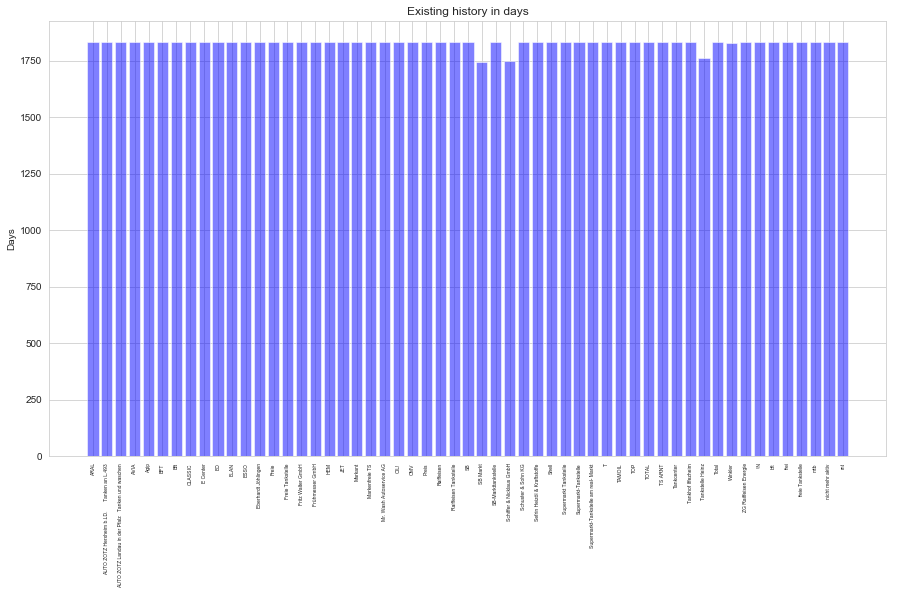

In [453]:
brands = stations.groupby("BRAND")
print(brands)
#get current time
now = dt.now()
dict = {}
plt.figure(figsize=(15,8))
for key, item in brands:
    brand_ids = brands.get_group(key)["ID"]
    rows_idx = prices["STID"].isin(brand_ids)
    time_stamps = prices.loc[rows_idx]["DATE_CHANGED"]
    time = time_stamps.apply(myfunc.time_stamp_to_date)
    min_time = time.min()
    days = (now-min_time).days
    dict[key] = days
y_pos = np.arange(len(dict.keys()))
plt.bar(y_pos, dict.values(), align='center', alpha=0.5, color = 'blue')    
plt.xticks(y_pos, dict.keys())
plt.ylabel('Days')
plt.title('Existing history in days')
plt.xticks(fontsize=5, rotation=90)
plt.show()

## Almost all brands have an equal and log history of activity

### 2. What is the min, mean, max price for each gasoline type weekly (time series graph)?

In [372]:
week_prices = prices.copy()
week_prices["DATE_CHANGED"] = week_prices["DATE_CHANGED"].apply(myfunc.time_stamp_to_week)

grouped_week = week_prices.groupby("DATE_CHANGED")
dict_e5 = {}
dict_e10 = {}
dict_diesel = {}

for week, item in grouped_week:
    current_group = grouped_week.get_group(week)
    min_e5 = myfunc.get_min(current_group["E5"], 10)/1000
    min_e10 = myfunc.get_min(current_group["E10"], 10)/1000
    min_diesel = myfunc.get_min(current_group["DIESEL"], 10)/1000
    
    max_e5 = current_group["E5"].max()/1000
    max_e10 = current_group["E10"].max()/1000
    max_diesel = current_group["DIESEL"].max()/1000
    
    mean_e5 =current_group["E5"].mean()/1000
    mean_e10 = current_group["E10"].mean()/1000
    mean_diesel =current_group["DIESEL"].mean()/1000
    
    dict_e5[week] = [min_e5, max_e5, mean_e5]
    dict_e10[week] = [min_e10, max_e10, mean_e10]
    dict_diesel[week] = [min_diesel, max_diesel, mean_diesel]


In [373]:
d3 = {k: v for k, v in dict_e5.items() if v[1] < 8} # cut the overpriced outliers (constrain max never be higher than 8 )
d4 = {k: v for k, v in dict_e10.items() if v[1] < 8} # cut the overpriced outliers
d5 = {k: v for k, v in dict_diesel.items() if v[1] < 8} # cut the overpriced outliers

In [374]:
def generate_plt_ticks(nr_ticks, list):
    """
    Genereate list of indexes and list of labels to show on axis of matplotlib plot.

    :param nr_ticks: Amount of ticks to generate
    :type nr_ticks: int
    :param list: List of labels
    :type list: list
    :return: list of indexes and list of labels
    """

    all_indexes = len(list)-1
    dist = all_indexes/(nr_ticks-1)
    index_list = []
    for nr in range(nr_ticks):
        index_list.append(int(nr*dist))
    tick_list = []
    for index in index_list:
        tick_list.append(list[index])
    return index_list, tick_list

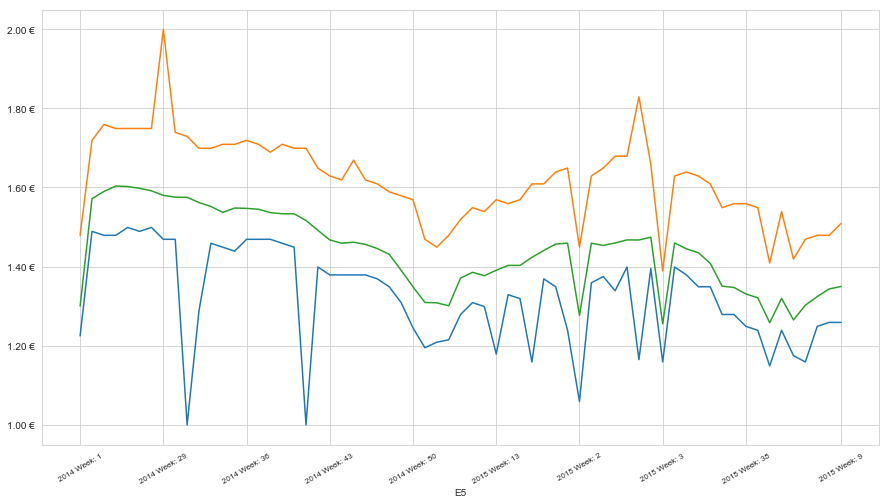

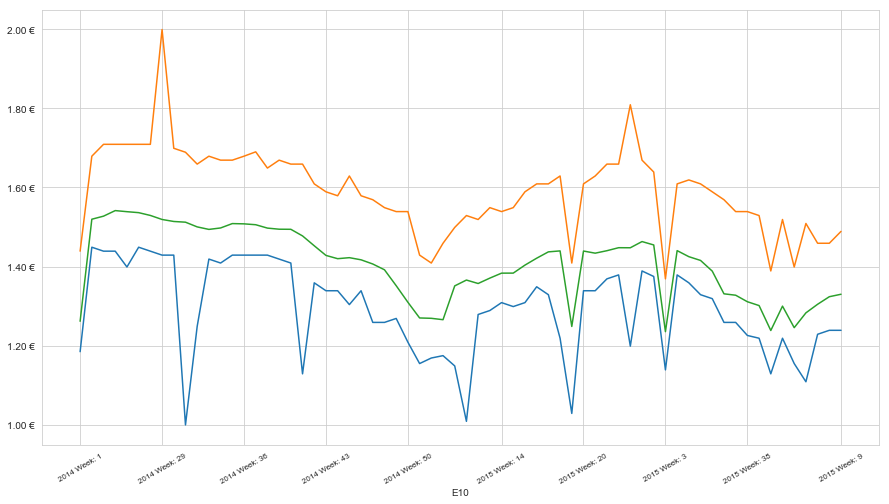

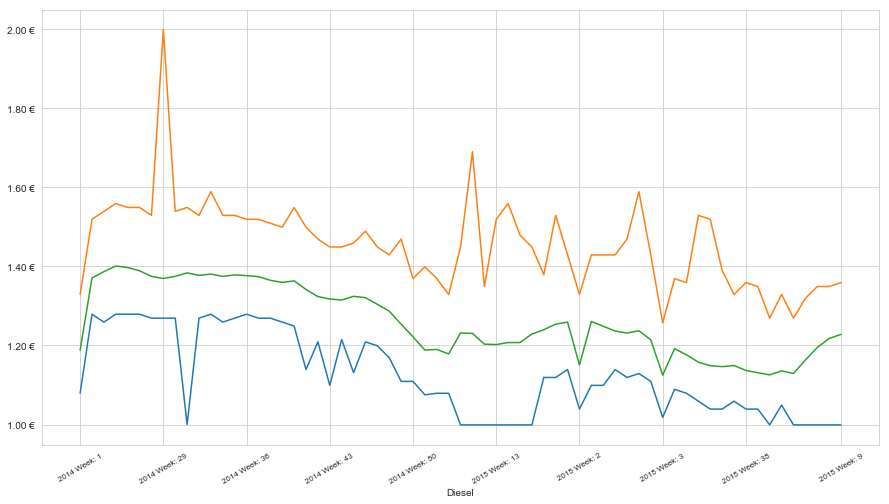

In [375]:
plt.figure(figsize=(15,8))
x_index_list, x_label_list = generate_plt_ticks(10, list(d3.keys()))
plt.xticks(x_index_list, x_label_list)
plt.plot(d3.keys(), d3.values())
plt.xlabel("E5")
plt.xticks(fontsize=8, rotation=30)
plt.gca().yaxis.set_major_formatter(tkr.FormatStrFormatter('%1.2f €'))
plt.show()

plt.figure(figsize=(15,8))
x_index_list, x_label_list = generate_plt_ticks(10, list(d4.keys()))
plt.xticks(x_index_list, x_label_list)
plt.plot(d4.keys(), d4.values())
plt.xlabel("E10")
plt.xticks(fontsize=8, rotation=30)  
plt.gca().yaxis.set_major_formatter(tkr.FormatStrFormatter('%1.2f €'))
plt.show()

plt.figure(figsize=(15,8))
x_index_list, x_label_list = generate_plt_ticks(10, list(d5.keys()))
plt.xticks(x_index_list, x_label_list)
plt.plot(d5.keys(), d5.values())
plt.xlabel("Diesel")
plt.xticks(fontsize=8, rotation=30)  
plt.gca().yaxis.set_major_formatter(tkr.FormatStrFormatter('%1.2f €'))
plt.show()

## LEGEND: yellow -> max, green -> mean, blue -> min

### 3. What is cheapest station(in average), why is it the cheapest?


In [377]:
id_grouped_prices = prices.groupby("STID")
min_average = 10000
min_id = 0
for id, item in id_grouped_prices:
    current_group = id_grouped_prices.get_group(id)
    #print(current_group[["E5"]])
    mean_e5 = (current_group[["E5"]][current_group[["E5"]] > 0]).mean().values[0]
    mean_e10 = (current_group[["E10"]][current_group[["E10"]] > 0]).mean().values[0]
    mean_diesel = (current_group[["DIESEL"]][current_group[["DIESEL"]] > 0]).mean().values[0]

    if not (math.isnan(mean_e5) or math.isnan(mean_e10) or math.isnan(mean_diesel)):
        average = (mean_e5+mean_e10+mean_diesel)/3
        if average < min_average:
            min_average = average
            min_id = id

print("Min_average: %1.2f" % (float(min_average)/1000.) + " €")
station_min = stations.loc[stations['ID'] == min_id]
print("The location of the cheapest gas station is: " + str(station_min["NAME"].values[0]) + " " + str(station_min["STREET"].values[0]) + " " + " " + str(station_min["POST_CODE"].values[0]) + " " + str(station_min["PLACE"].values[0]))


Min_average: 1.28 €
The location of the cheapest gas station is: Winkler-Kaiserslautern Mainzerstraße  67657 Kaiserslautern


## The reason why is it so cheap can be several. I think one of them could be possible due  to being in close proximity to gas containers and as such the distance to refuel this gas station is smaller than to others. Because of this we do not spend much on transportation.

### 4.At which day of a week is the price most likely the cheapest(week profile)?

In [378]:
prices['WEEKDAY'] = pd.to_datetime(prices['DATE_CHANGED']).apply(pd.datetime.weekday)
weekdays_prices = prices.groupby(['WEEKDAY'])['DIESEL', 'E5', 'E10'].mean().sum(axis = 1) / 4000 # take 4000 to normilize the sum

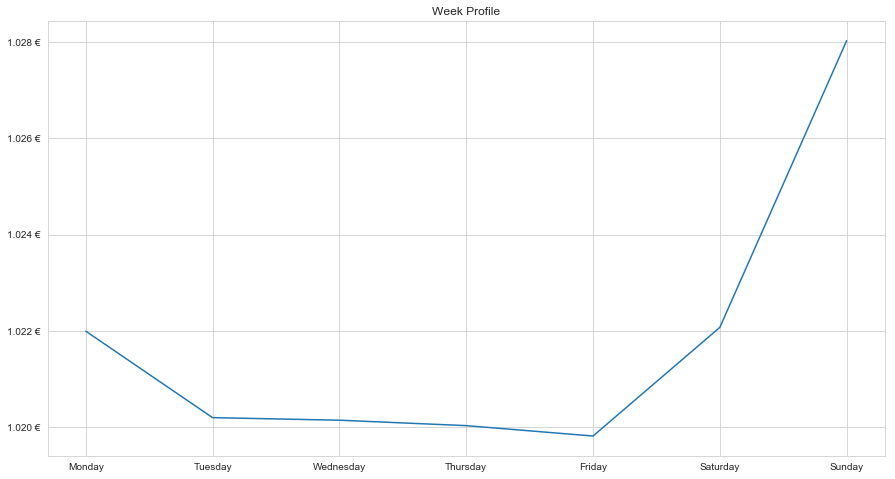

In [379]:
plt.figure(figsize=(15,8))
plt.title('Week Profile')
plt.gca().yaxis.set_major_formatter(tkr.FormatStrFormatter('%1.3f €'))
plt.plot(calendar.day_name[0:7], weekdays_prices)

## It appears to be that the cheapest day is Friday

### 5. At which hour during a day is the price the cheapest (hour profile)?

In [380]:
prices['HOUR'] = [pd.to_datetime(x).hour for x in prices['DATE_CHANGED']]
hours_prices = prices.groupby(['HOUR'])['DIESEL', 'E5', 'E10'].mean().sum(axis=1) / 4000

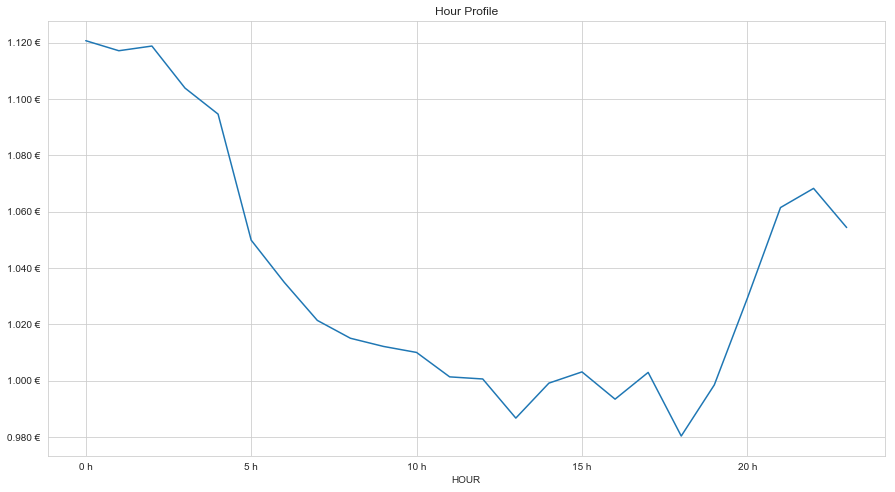

In [381]:
plt.figure(figsize=(15,8))
plt.title('Hour Profile')
plt.gca().yaxis.set_major_formatter(tkr.FormatStrFormatter('%1.3f €'))
plt.gca().xaxis.set_major_formatter(tkr.FormatStrFormatter('%d h'))
hours_prices.plot(figsize=(15,8))

## It appears to be that the cheapest hour is around 17 h

### 6. How many different locations are present in the data(visualize via a map)?

In [382]:
unique_locations = stations['PLACE'].unique()
print("The data set contains stations from %d different cities" %len(unique_locations))

The data set contains stations from 199 different cities


In [423]:
map_df = gpd.read_file('map/de.shp')

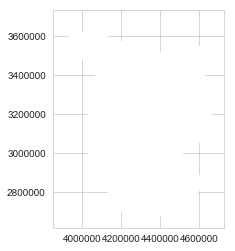

In [424]:
map_df.plot()

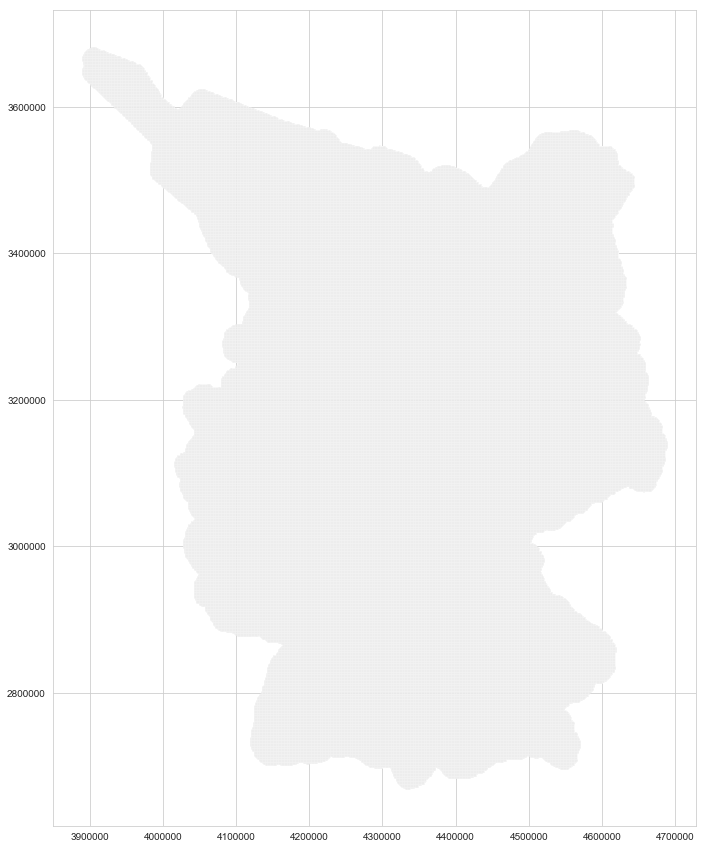

In [425]:
fig, ax = plt.subplots(figsize = (15,15))
map_df.plot(ax = ax, alpha = 0.4, color = 'grey')

In [426]:
from shapely.geometry import Point
# creating a geometry column 
geometry = [Point(xy) for xy in zip(stations['LNG'], stations['LAT'])]
# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

In [427]:
min_lat = min(stations['LAT'])
max_lat = max(stations['LAT'])
min_lng = min(stations['LNG'])
max_lng = max(stations['LNG'])

coordinates = gpd.GeoDataFrame(stations,crs = crs, geometry=geometry)

,ID,VERSION,VERSION_TIME,NAME,BRAND,STREET,POST_CODE,PLACE,PUBLIC_HOLIDAY_IDENTIFIER,LAT,LNG,geometry
0,d37bee76-91b6-485a-b974-24f1b0d391fa,4,2015-01-09 10:26:15.000000,Aral Tankstelle,ARAL,An der Tagweide,76139,Karlsruhe,\N,49.020280,8.459429,POINT (8.459429 49.0202799)
1,51d4b652-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET MANNHEIM UNTERMUEHLAUSTRASSE 83,JET,UNTERMUEHLAUSTRASSE 83,68169,MANNHEIM,\N,49.508962,8.467691,POINT (8.467691 49.5089619)
2,c7caf231-0e47-40db-92de-9349a2eb2bef,4,2014-09-26 13:24:57.000000,Aral Tankstelle,ARAL,Trippstadter Straße,67663,Kaiserslautern,\N,49.433754,7.757465,POINT (7.7574649 49.433754)
3,51d4b53b-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET KAISERSLAUTERN PARISER STR. 167,JET,PARISER STR. 167,67655,KAISERSLAUTERN,\N,49.442200,7.748360,POINT (7.748359900000001 49.4421999)
4,51d4b70f-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET GERMERSHEIM MUENCHENER STRASSE 12,JET,MUENCHENER STRASSE 12,76726,GERMERSHEIM,\N,49.226800,8.374400,POINT (8.3743999 49.2267999)


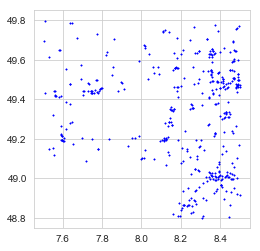

In [428]:

# Plot all points
coordinates.plot(marker='o', color='b', markersize=0.5)
coordinates.head()

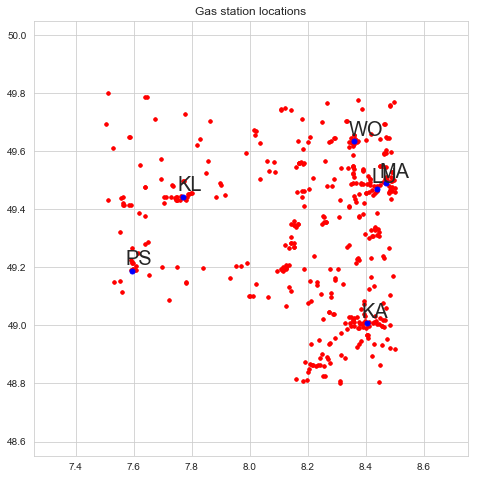

In [429]:
ax = map_df.plot(color = 'lightgrey', linewidth = 0.5, edgecolor = 'black', figsize=(15,8))

ax.set_title("Gas station locations")
ax.set_xlim(min_lng - 0.25, max_lng + 0.25)
ax.set_ylim(min_lat - 0.25, max_lat + 0.25)

cities = {
    'KL': 'Kaiserslautern',
    'MA': 'Mannheim',
    'LU': 'Ludwigshafen',
    'KA': 'Karlsruhe',
    'PS': 'Pirmasens',
    'WO': 'Worms'
}

geolocator = Nominatim(user_agent='cities', timeout=10) 
for abb, name in cities.items():
    location = geolocator.geocode(name)
    ax.text(location.longitude - 0.02, location.latitude + 0.02, abb, fontsize=20)
    ax.plot(location.longitude, location.latitude, 'ok', color='blue', markersize=5)

geo_df = gpd.GeoDataFrame(coordinates, crs = {'init': 'epsg:4326'}, geometry = coordinates['geometry'])
geo_df.plot(markersize = 10, ax = ax, color='red')

### 7. What is the gas station which has most price data points, choose one and draw the time seriesfor all 3 gas types

In [438]:
number_of_datapoints = prices.groupby(['STID']).size()
most_data_points = number_of_datapoints[number_of_datapoints == max(number_of_datapoints)] 
data_points = prices[prices['STID'] == most_data_points.index[0]]

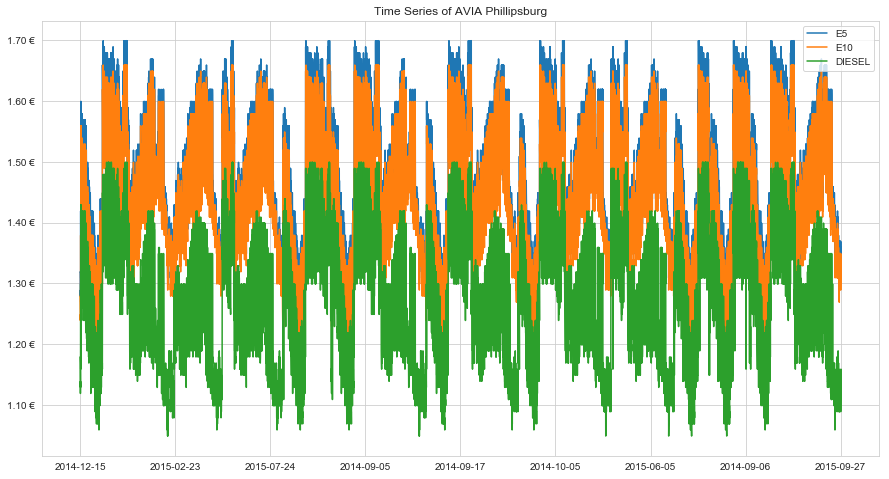

In [433]:
plt.figure(figsize=(15,8))

plt.plot(data_points['E5'].values / 1000, label = 'E5')
plt.plot(data_points['E10'].values / 1000, label = 'E10')
plt.plot(data_points['DIESEL'].values / 1000, label = 'DIESEL')
plt.legend(loc='upper right')
date_list = list(data_points['DATE_CHANGED'].apply(lambda x: x.split(" ")[0]))
indexs = range(len(date_list) - 1)[::int(len(date_list) / 8)]
ticks = date_list[0:len(date_list) - 1:int(len(date_list) / 8)]
plt.xticks(indexs, ticks)

plt.title('Time Series of ' + stations[stations['ID'] == most_data_points.index[0]]['NAME'].values[0])
plt.gca().yaxis.set_major_formatter(tkr.FormatStrFormatter('%1.2f €'))

### The Diesel is the cheapest fuel at this gas stations

In [323]:
stations[stations['ID'] == most_data_points.index[0]]['NAME'].values[0]

'AVIA Phillipsburg'

### 8. At which hour during a day do we have the most price changes?

In [327]:
def price_changes(df):
    diesel_mask = 3
    diesel_changed = 1

    e5_mask = 12
    e5_changed = 4

    e10_mask = 48
    e10_changed = 16
        
    change = 0
    
    if int(df['CHANGED']) & diesel_mask == diesel_changed:
        change = 1
    elif int(df['CHANGED']) & e5_mask == e5_changed:
        change = 1
    elif int(df['CHANGED']) & e10_mask == e10_changed:
        change = 1
        
    return change

In [329]:
prices['PRICE_CHANGE'] = prices.apply(price_changes, axis=1)

In [337]:
number_of_days = prices.groupby('STID')['DATE_CHANGED'].nunique()
number_of_days.columns = ['NUMBER OF DAYS']

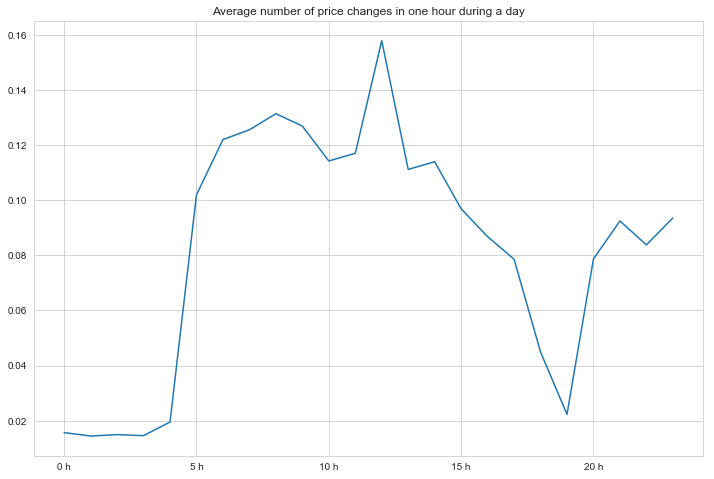

In [339]:
number_of_price_changes = prices.groupby('HOUR')['PRICE_CHANGE'].sum()
number_of_price_changes = number_of_price_changes / (len(unique_stids_price) * number_of_days.mean())

plt.figure(figsize=(12,8))
plt.title('Average number of price changes in one hour during a day')
plt.gca().xaxis.set_major_formatter(tkr.FormatStrFormatter('%d h'))
plt.plot(number_of_price_changes)

## We have the most price changes in the between 10 h and 15 h

### 9. Select 20 gas stations having the longest time history and visualize the average price per month. Use heatmapand only the prices between 12:00-13:00of e10and diesel.

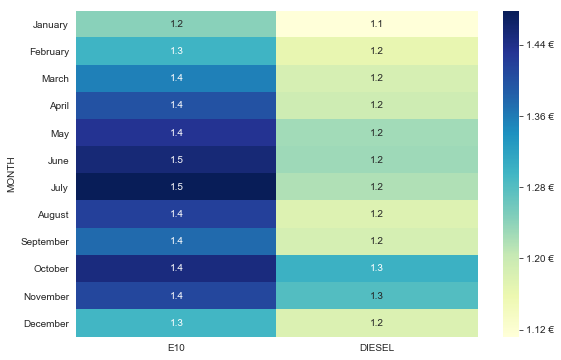

In [347]:
longest_history = number_of_days.sort_values().tail(20)
longest_history = (prices[prices['STID'].isin(longest_history.index)])
between_12_13 = longest_history[longest_history['HOUR'] == 12]
between_12_13['MONTH'] = [pd.to_datetime(x).month for x in between_12_13['DATE_CHANGED']]

month = between_12_13.groupby('MONTH')["E10", "DIESEL"].mean() / 1000

plt.figure(figsize=(9,6))
sns.heatmap(month, annot=True, cmap="YlGnBu", cbar_kws={'format': '%1.2f €'}, yticklabels=calendar.month_name[1:13]  ) 

# The results above could help a car fleet  save money on refueling its vehicles.  To obtain that, the car fleet could do the followings:
## 1. Refuel on Tuesday - Friday, especially on Friday since it is the cheapest day, although we will not save much, around 0.008 €.
## 2. Always refuel between 14pm and 17 pm. We can save up to 22 cents per liter if we refuel at 17 pm, (1.20 € to 0.98 € at 17pm).
## 3. It seems that Diesel is the most cheapest fuel. E5 max average is 1.60 € while Diesel's 1.40 €. We can save 20 cents each time we refuel with Diesel.
## The month seems not to influence the prices much, so the customer is free  in that regard

## There are some contraints to the arguments presented above. The cheap fuel stations must be in range of customers otherwise the customer should re-evaluate the loss based on distance and price.
## The cheapest hours may also be not good because of various reasons such as the customer cannot be at that time near the gas station, or the gas station is closed.
## Unavailability of the cheapes fuel could also be a problem and the customer would be forced to buy a different fuel with a higher price